In [1]:
import nbsetup
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chisquare, chi2_contingency
from helpers.ergodic import ErgodicEnsemble

ModuleNotFoundError: No module named 'helpers'

# Setting up the standard code

In [ ]:
MAX = 20

def mod(i, x, y, n=2):
    return x if i % n else y
    
def ran(i, x, y):
    return np.random.uniform(x, y)


CASES_TRUE = {
    "power 2": lambda i, o: np.random.power(2,o)*MAX,
    "power 4": lambda i, o: np.random.power(4,o)*MAX,
    "power 6": lambda i, o: np.random.power(6,o)*MAX,
    "power 8": lambda i, o: np.random.power(8,o)*MAX,
    "normal": lambda i, o: np.random.normal(MAX, 0.5, o),
    "uniform": lambda i, o: np.random.uniform(0, MAX, o)
}

CASES_FLIP = {
    "flip power 4-6": lambda i, o: np.random.power(mod(i, 4, 6),o)*MAX,
    "flip power 4-4.5": lambda i, o: np.random.power(mod(i, 4, 4.5),o)*MAX,
    "flip power 2-3": lambda i, o: np.random.power(mod(i, 2, 3),o)*MAX,
    "flip power 2-2.5": lambda i, o: np.random.power(mod(i, 2, 2.5),o)*MAX,
    "flip power 2-2.1": lambda i, o: np.random.power(mod(i, 2, 2.1),o)*MAX,
    "flip normal 5-8": lambda i, o: np.random.normal(mod(i, 5, 8),0.5,o),
    "flip normal 5-6": lambda i, o: np.random.normal(mod(i, 5, 6),0.5,o),
    "flip normal 5-5.2": lambda i, o: np.random.normal(mod(i, 5, 5.2),0.5,o),
    "flip normal 5-5.1": lambda i, o: np.random.normal(mod(i, 5, 5.1),0.5,o),
}

CASES_RAND = {
    "power 4-6": lambda i, o: np.random.power(ran(i, 4, 6),o)*MAX,
    "power 4-4.5": lambda i, o: np.random.power(ran(i, 4, 4.5),o)*MAX,
    "power 2-3": lambda i, o: np.random.power(ran(i, 2, 3),o)*MAX,
    "power 2-2.5": lambda i, o: np.random.power(ran(i, 2, 2.5),o)*MAX,
    "power 2-2.1": lambda i, o: np.random.power(ran(i, 2, 2.1),o)*MAX,
    "normal 5-8": lambda i, o: np.random.normal(ran(i, 5, 8),0.5,o),
    "normal 5-6": lambda i, o: np.random.normal(ran(i, 5, 6),0.5,o),
    "normal 5-5.2": lambda i, o: np.random.normal(ran(i, 5, 5.2),0.5,o),
    "normal 5-5.1": lambda i, o: np.random.normal(ran(i, 5, 5.1),0.5,o),
}


def get_results(gen, name, b, o, ensembles, trials, force):
    filename = "../datasets/chisquare/%s.json" % ("-".join([str(n) for n in (name, b, o, ensembles, trials)]))
    
    if not force: # force refresh skip load
        try:
            nbsetup.cp("loading", name, b, o)
            with open(filename, 'r') as myfile:
                data = json.loads(myfile.read())
                return data
        
        except FileNotFoundError:
            pass
    
    # generate
    nbsetup.cp("generating", name, "bins", b, "observations", o, "ensembles", ensembles)
    data = create_results(gen, name, b, o, ensembles, trials)
    
    # now save generation
    with open(filename, "w") as outfile:
        json.dump(data, outfile)
    
    return data
    
def create_results(gen, name, b, o, ensembles, trials):
    results = []
    for t in range(trials):        
        # generate data
        observations = []
        for e in range(ensembles):
            observations.append(gen(e, o))
        observations = np.array(observations)
        # create EE
        bins = np.linspace(int(np.floor(observations.min())), int(np.ceil(observations.max())), max(b+1,3))
        ee = ErgodicEnsemble(observations=observations, bins=bins)
        
        results.append({
            'bin': b,
            'obs': o,
            'dist': name,
            'ensembles': ensembles,
            'complexity': ee.complexity,
            'complexity2': ee.complexity2,
            'complexity4': ee.complexity4,
            'ergodic': ee.ergodic,
            'p': ee.chisquare_p,
        })
    return results
    

def gen_data(cases, bin_range, obs_range, ensembles=2, trials=1000, force=False):
    data = []
    for name, gen in cases.items():
        for b in bin_range:
            for o in obs_range:
                data += get_results(gen, name, b, o, ensembles, trials, force)
    nbsetup.cp("finished gen_data")
    return data

# Baselining against information radius

In [6]:
from helpers.entropy import shannon_entropy
def kl_divergence(p, q):
    s = 0
    for i, pi in enumerate(p):
        if pi != 0 and q[i] != 0:
            s += pi * np.log(pi / q[i])
    return s  
    
def comparison(pmfs):
    # normalise
    pmfs = np.array(pmfs)/np.sum(pmfs)
    
    # avg pmf
    erg = pmfs.mean(axis=0)
    
    # KL Div version
    info_radius = np.mean([kl_divergence(p, erg) for p in pmfs])
    
    # complexity
    comp = shannon_entropy(erg) - np.mean([shannon_entropy(p) for p in pmfs])
    return info_radius, comp*np.log(2)

# Baselining ChiSquare

In [65]:
ID_VARS = ['obs', 'bin', 'dist', 'ensembles']
DROP_VARS = ['complexity','complexity2','complexity4','ergodic','p']

def apply_p_tf(df):
    """ Standard p-value calcs """
    df = df.assign(_p = 0)
    
    for p in [0.05, 0.01]:
        name = 'p > %.2f' % p
        # zero it out
        df[name] = 0
        # then set those gt
        idx = df[df['p'] > p].index
        df.loc[idx, name] = 1.0
    
    df = df.drop(columns=['_p'])
    return df

def apply_complexity_2_tf(df):
    """ Best (current) version for 1st moment complexity for 2 ensembles """
    df = df.assign(_c = lambda r: (r.complexity*r.obs)-(r.bin/15))
    
    for c in [1.4, 2.0]:
        name = 'c < %.1f' % c
        # zero it out
        df[name] = 0
        # then set those lt
        idx = df[df['_c'] < c].index
        df.loc[idx, name] = 1.0
    
    df = df.drop(columns=['_c'])
    return df


def apply_complexity2_2_tf(df):
    """ Best (current) version for 2nd moment complexity for 2 ensembles """
    df = df.assign(_v = lambda r: r['complexity2']*r.obs/r.ergodic)
    
    for v in [2.0, 1.0]:
        name = 'c2 < %s' % v
        # zero it out
        df[name] = 0
        # then set those lt
        idx = df[df['_v'] < v].index
        df.loc[idx, name] = 1.0
    
    df = df.drop(columns=['_v'])
    return df

In [14]:
def relplot(dataframe, dist_filters=None, absolute=False):
    nbsetup.cp("Plotting")
    # print relplot of the absolute values
    filt = dataframe
    if dist_filters is not None:
        filt = filt[filt['dist'].isin(dist_filters)]
    filt = filt.drop(columns=DROP_VARS) # easier to drop vars than to add others to value_vars
    melt = filt.melt(id_vars=ID_VARS)
    g = sns.relplot(data=melt, kind='line', col='bin', row='dist', x='obs', y='value', hue='variable', legend='full')
    
    # if comparing absolute values
    if absolute:
        g.map(plt.axhline, y=0.05, color=".7", dashes=(2, 1), zorder=0)
        g.map(plt.axhline, y=0.01, color=".7", dashes=(2, 1), zorder=0)
        g.set(xscale="log", yscale="log", ylim=(0.0001,1.0))
        g.set_axis_labels("Observations", "p-value")
        g.tight_layout(w_pad=0)
    else:
        #g.set(xscale="log")
        g.set(ylim=(-0.01,1))
    nbsetup.cp("")

# Investigations

In [5]:
double = pd.DataFrame(gen_data(CASES, [2,5,10,15,20], [100,500,1000,2000], ensembles=2))

finished gen_data


In [37]:
csc = CASES_TRUE.copy()
csc.update(CASES_FLIP)

multiple_flip = pd.DataFrame(gen_data(csc, [2,5,10,15,20], [50, 100,500,1000,2000], ensembles=20))


finished gen_data


In [38]:
csc = CASES_TRUE.copy()
csc.update(CASES_RAND)

multiple_rand = pd.DataFrame(gen_data(csc, [2,5,10,15,20], [50, 100,500,1000,2000], ensembles=20))

finished gen_data


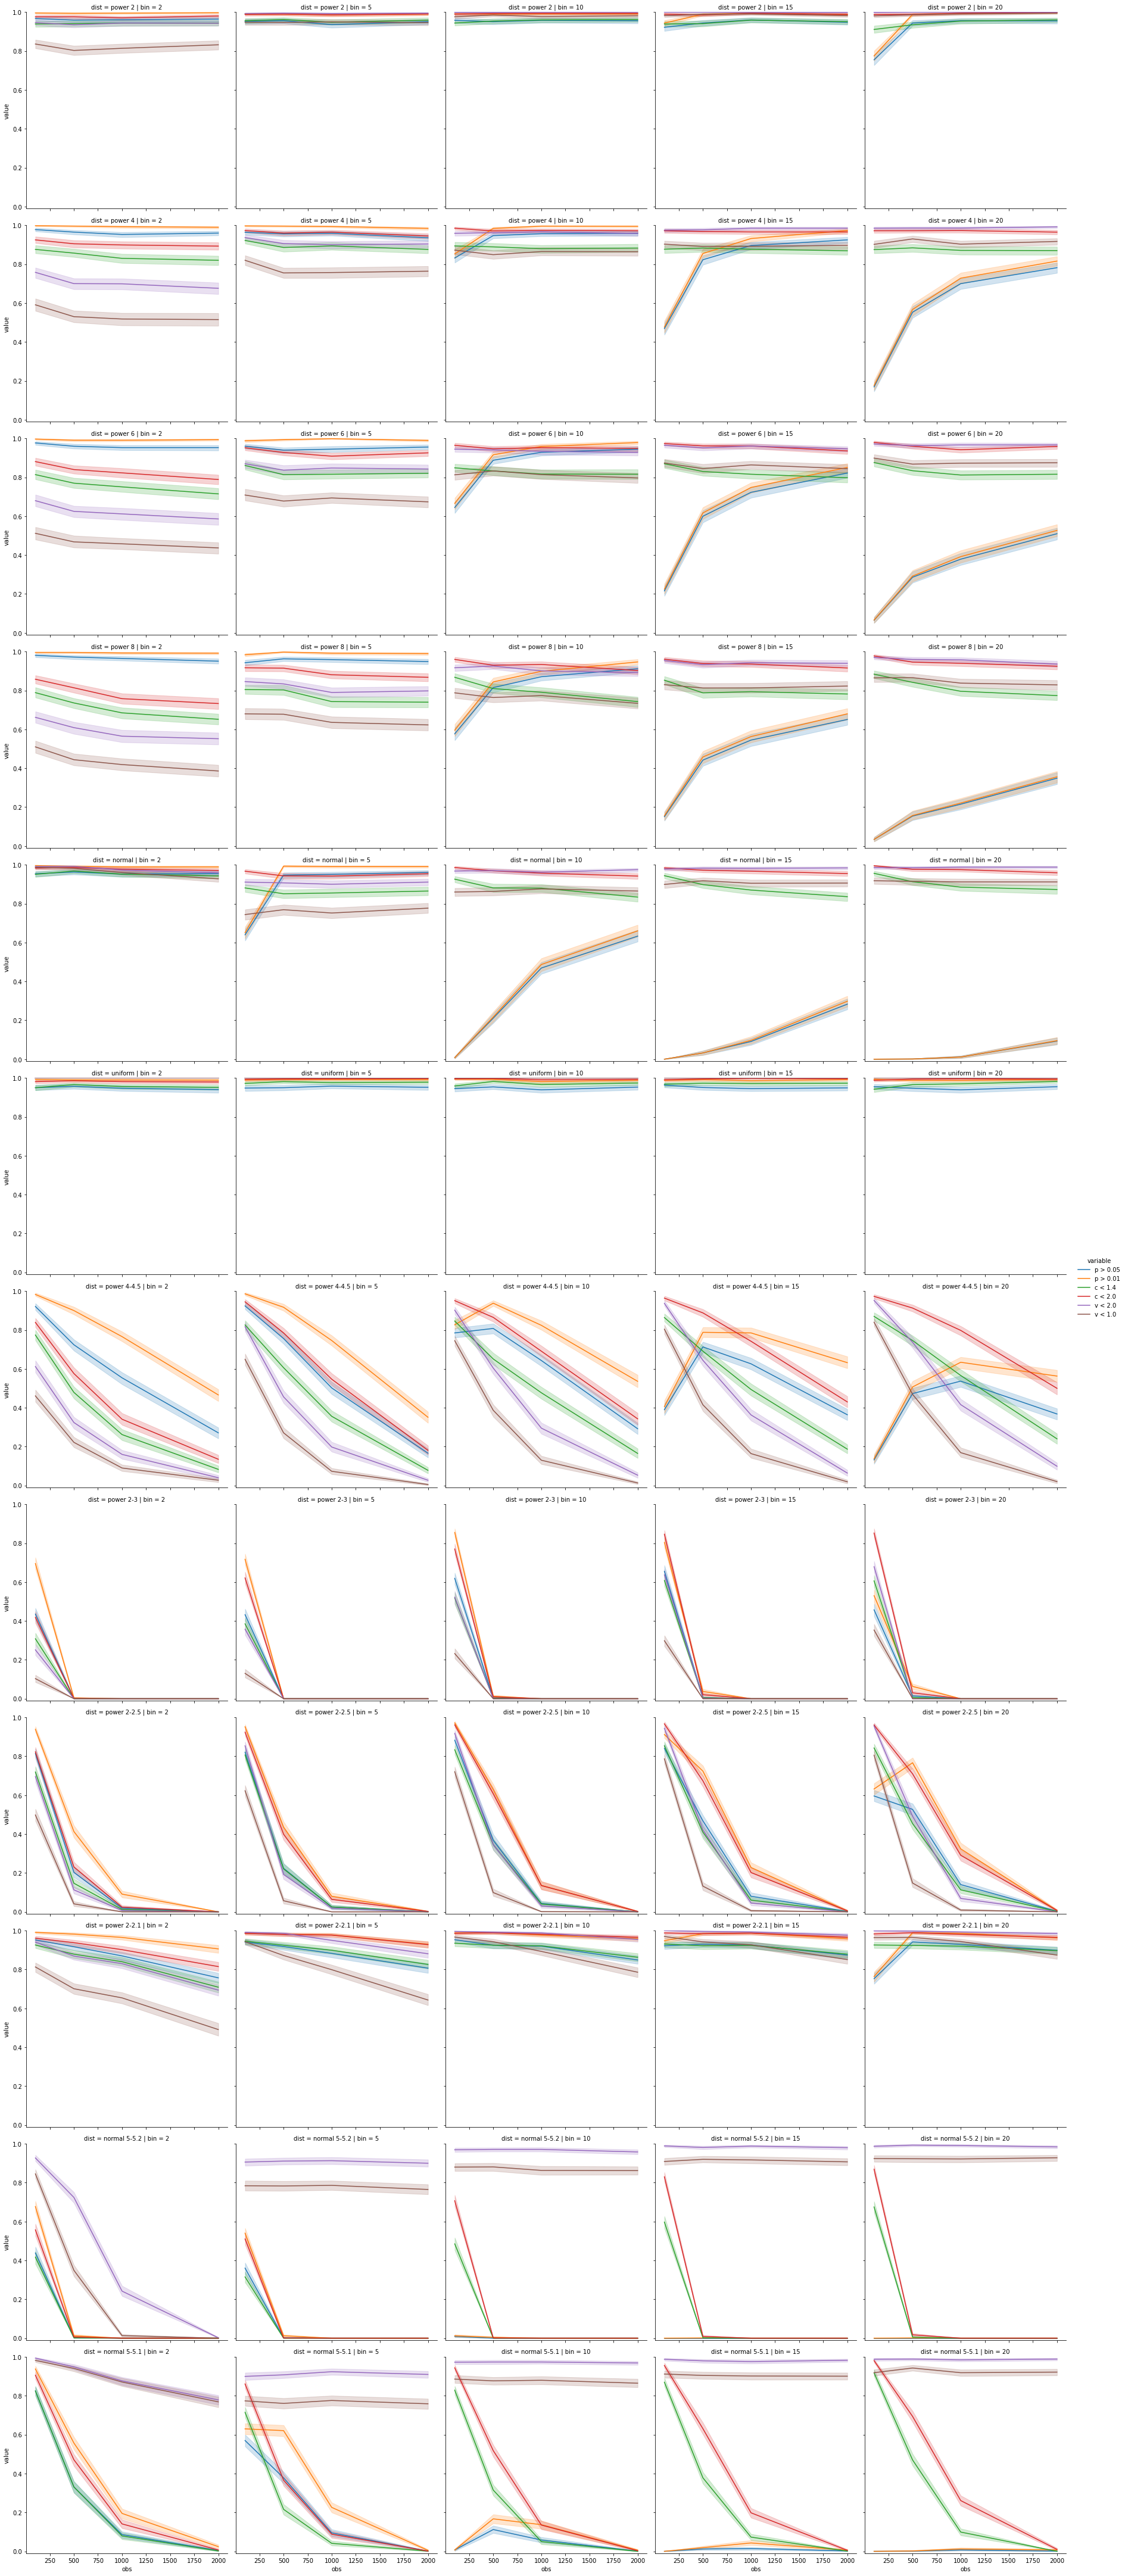

In [20]:
trans = apply_p_tf(double)
trans = apply_complexity_2_tf(trans)
trans = apply_complexity2_2_tf(trans)
relplot(trans)

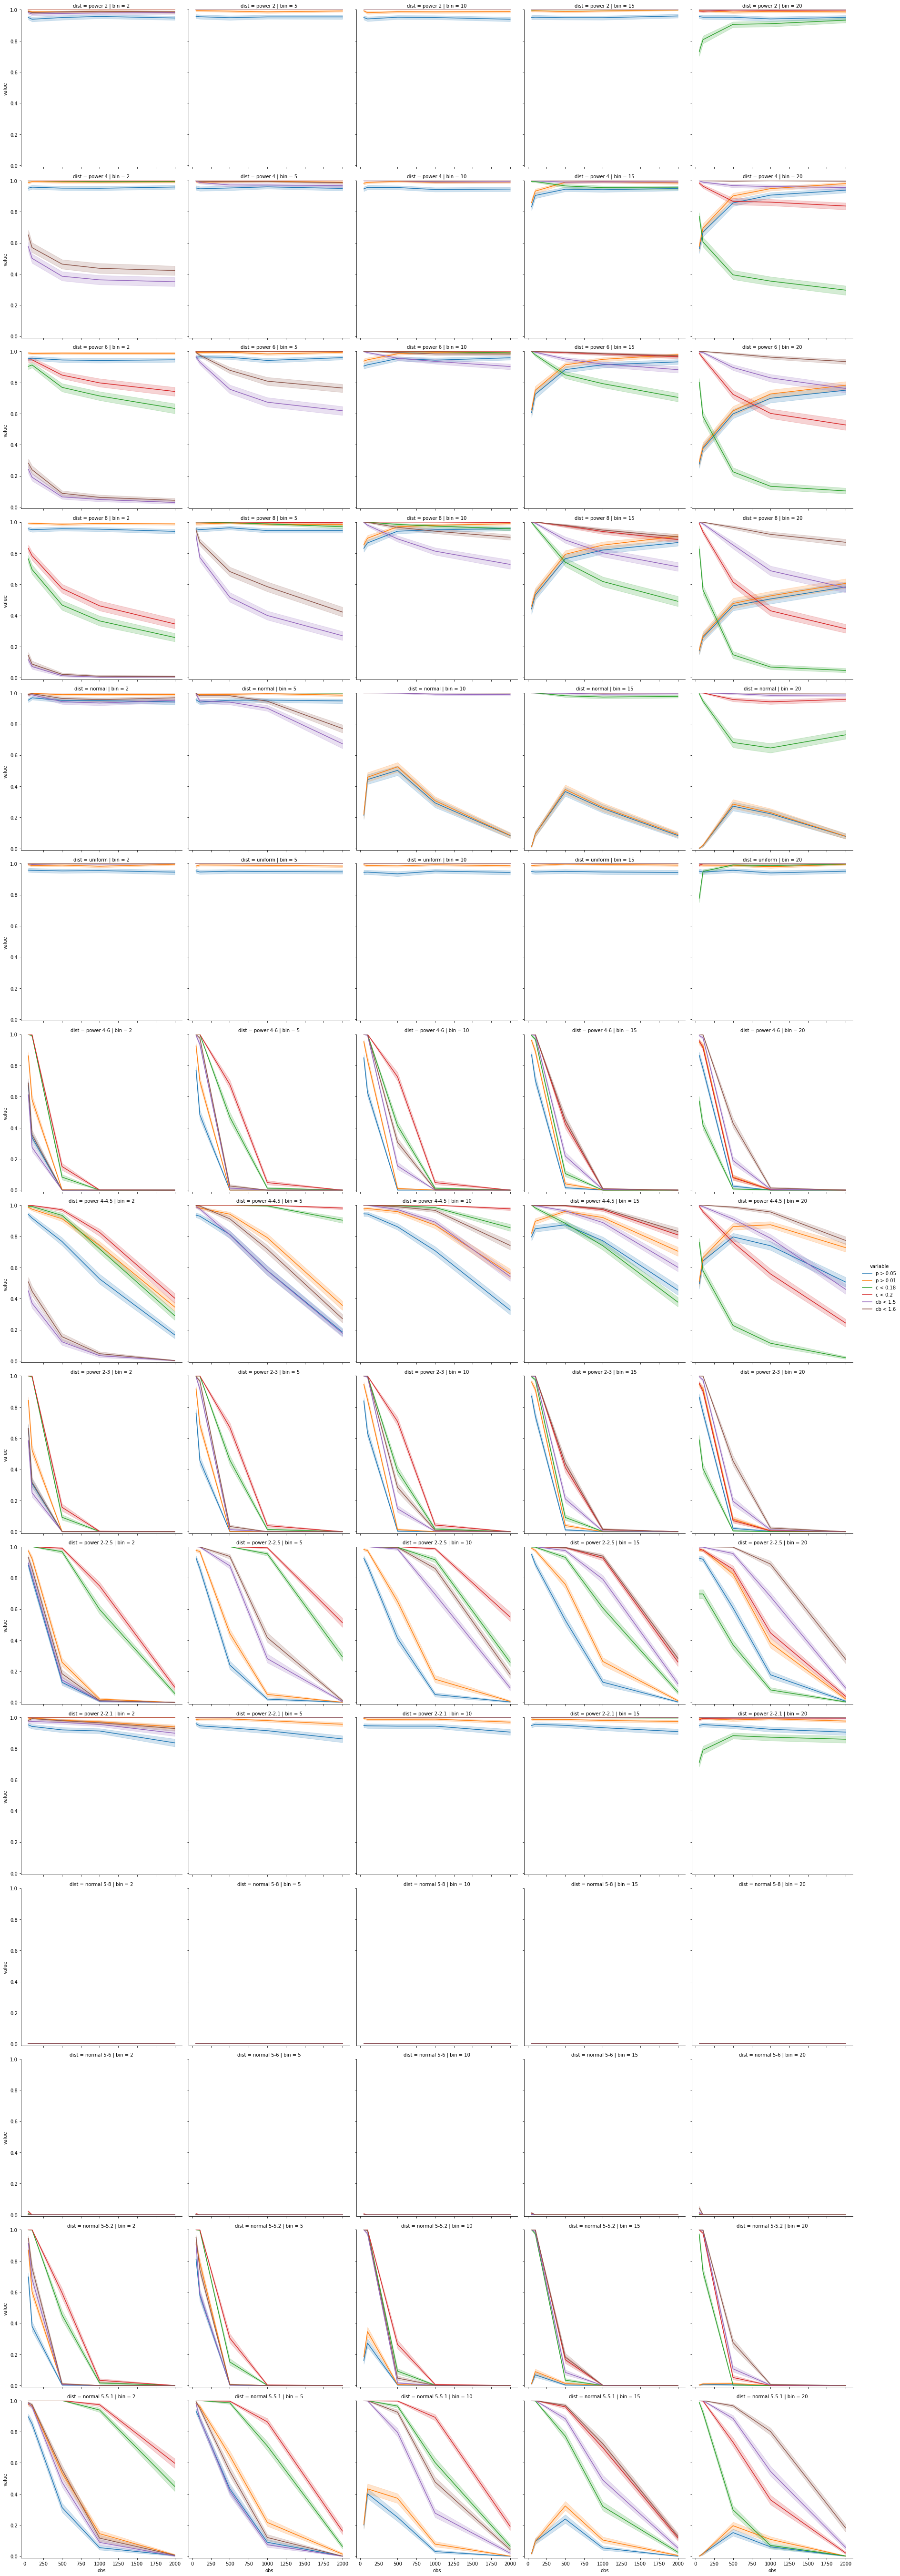

In [67]:
def apply_complexity_20_tf(df):
    """ Best (current) version for 2nd moment complexity for 2 ensembles """
    
    # reducing this number, increases height
    df = df.assign(_v = lambda r: (r.complexity*r.obs)/r.ensembles)
    # increasing this number increases height
    for v in [0.18, 0.20]:
        name = 'c < %s' % v
        # zero it out
        df[name] = 0
        # then set those lt
        idx = df[df['_v'] < v].index
        df.loc[idx, name] = 1.0
    
    df = df.drop(columns=['_v'])
    return df

def apply_alt_complexity_20_tf(df):
    """ Best (current) version for 2nd moment complexity for 2 ensembles """
    
    # reducing this number, increases height
    df = df.assign(_v = lambda r: (r.complexity*r.obs)/((r.bin-1)**0.35))
    
    # increasing this number increases height
    for v in [1.5, 1.6]:
        name = 'cb < %s' % v
        # zero it out
        df[name] = 0
        # then set those lt
        idx = df[df['_v'] < v].index
        df.loc[idx, name] = 1.0
    
    df = df.drop(columns=['_v'])
    return df

trans = apply_p_tf(multiple)
trans = apply_complexity_20_tf(trans)
trans = apply_alt_complexity_20_tf(trans)
relplot(trans)

In [ ]:
%%time
mini_names = ['power 2', 'power 6', 'power 8', 'normal', 'power 2-3', 'normal 5-5.2']
mini_cases = dict([(name, CASES[name]) for name in mini_names])

small = pd.DataFrame(gen_data(CASES, [2,5,10,20], [100,500,1000,2000], ensembles=20))

rules_20 = {
    'p5': lambda r: 1.0 if r.p > 0.05 else 0.0,
    #'p1': lambda r: 1.0 if r.p > 0.01 else 0.0,
    
    # current testing mess
    #'c @2': lambda r: 1.0 if r.complexity < (2+(r.bin/15))/r.obs else 0.0,
    'c3 @20':lambda r:  1.0 if r.complexity < (3+(r.bin/10))/r.obs else 0.0,
    'c2 @20':lambda r:  1.0 if r.complexity < (2+(r.bin/10))/r.obs else 0.0,
    'c1.5 @20':lambda r:  1.0 if r.complexity < (1.5+(r.bin/10))/r.obs else 0.0,
}

#relplot(tf_transform(small, rules_20))

# Calculating adjustment for bin

There appears to be a relationship between the number of bins (which is akin to degree's of freedom with chisquare). Investigating what that relationship might be.

- After plotting, it appears to be linear.
- After then plotting for for each different distribution, the relationship is consistent.
- It's so consistent even what looks to be minor variance bumps are consistent. However, we'll ignore these for now for the sake of simplicity.

### Bins over distributions

In [ ]:
bin_500 = pd.DataFrame(gen_data(CASES, range(2,16,2), [500], ensembles=20))

In [ ]:
bin_1000 = pd.DataFrame(gen_data(CASES, range(2,16,2), [1000], ensembles=20))

In [ ]:
def regressions(df):
    regressions = {}
    for k in df['dist'].unique():
        means = df[df['dist']==k].loc[:,['bin','dist','complexity']].groupby('bin').mean()
        x = means.reset_index()['bin']
        y = means['complexity']
        model = np.polyfit(x, y, 1)
        regressions[k] = model[0]
    return regressions

def plot_regressions(df):
    melt = df.melt(id_vars=['dist','bin','obs'])
    sns.lineplot(data=melt, x='bin', y='value', hue='variable')

In [ ]:
for o in [300, 400, 1500, 2000]:
    bin_results[o] = regressions(pd.DataFrame(gen_data(CASES, range(2,16,2), [o], ensembles=10)))

df_regs = pd.DataFrame(bin_results).T
df_regs.reset_index(inplace=True)
sns.lineplot(data=df_regs.melt(id_vars='index'), x='index', y='value', hue='variable')

In [ ]:
df_regs

In [ ]:
regressions = {}
for dist in CASES.keys():
    regressions[dist] = calc_bin_regression(dist, obs=1000)

In [ ]:
regressions

### Bins over observations

In [ ]:
obs_regressions = {}
checkers = [
    (100, [2,5]),
    (200, [2,5,8,10]),
    (500, [2,5,8,10,15]),
    (800, [2,5,8,10,15]),
    (1000, [2,5,8,10,15,20]),
    (1500, [2,5,8,10,15,20]),
    (2000, [2,5,8,10,15,20]),
]
for obs, bins in checkers:
    obs_regressions[obs] = calc_bin_regression('normal', obs, bins)
obs_regressions

### Adjusting for bin

In [ ]:
bin_m = regressions['power 2'][0]

In [ ]:
normal_check = pd.DataFrame(gen_data({'normal':CASES['normal']}, [3,5,7,10], [100, 500, 1000, 2000], trials=100, ensembles=20))

In [ ]:
def check_regression_calc(data):
    data = data.assign(adjust = lambda r: r.complexity-bin_m*r.bin)
    data = data.drop(columns=['c','p'])
    melt = data.loc[:,['obs','bin','dist','complexity']].melt(id_vars=['obs', 'bin', 'dist'])
    #g = sns.relplot(data=melt, kind='line', col='bin', row='dist', x='obs', y='value', hue='variable', legend='full')
    g = sns.lineplot(data=melt, x='obs', y='value', hue='bin', legend='full')
    return data
    
check_regression_calc(normal_check)

# Observation regressions

In [ ]:
def calc_bin_regression(dist, obs=500):
    data = pd.DataFrame(gen_data({dist:CASES[dist]}, range(2,52,1), [obs], trials=1000, ensembles=20))
    means = data.loc[:,['bin','complexity']].groupby('bin').mean()
    x = means.reset_index()['bin']
    y = means['complexity']
    model = np.polyfit(px, py, 1)
    g = sns.lineplot(data=bin_madness, x="bin", y="complexity")
    g.set_title(dist)
    return model